In [3]:
#Install cpu only version of torchvision, for accessing MNIST dataset
#GPU version may have compatibility issues with JAX
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu  

In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".9"
import jax.numpy as jnp
from jax.nn import log_softmax,one_hot
from jax import grad,vmap,jacobian
from jax.lax import dynamic_slice,dynamic_slice_in_dim
from jax.lax import dynamic_update_slice
import jax
import gc


In [5]:
batch_size=10000
sg_no_batches=60000//batch_size

import torchvision
def get_dataset_torch():
    mnist = {
        'train': torchvision.datasets.MNIST('./data', train=True, download=True),
        'test': torchvision.datasets.MNIST('./data', train=False, download=True)
    }

    ds = {}

    for split in ['train', 'test']:
        ds[split] = {
            'image': mnist[split].data.numpy(),
            'label': mnist[split].targets.numpy()
        }

        # cast from np to jnp and rescale the pixel values from [0,255] to [0,1]
        ds[split]['image'] = jnp.float32(ds[split]['image']) / 255.0
        ds[split]['label'] = jnp.int16(ds[split]['label'])

        # torchvision returns shape (B, 28, 28).
        # hence, append the trailing channel dimension.
        ds[split]['image'] = jnp.expand_dims(ds[split]['image'], 3)

    return ds['train'], ds['test']

train, test = get_dataset_torch()
train['image']=train['image'].reshape([60000,28*28])
train['image']=jnp.concatenate((train['image'],jnp.ones([60000,1])),1)
key=jax.random.key(34523)
rand_perm=jax.random.permutation(key,60000)
train['image']=train['image'][rand_perm,:]
train['label']=one_hot(train['label'],10)
train['label']=train['label'][rand_perm,:]
test['image']=test['image'].reshape([10000,28*28])
test['image']=jnp.concatenate((test['image'],jnp.ones([10000,1])),1)
test['label']=one_hot(test['label'],10)

In [3]:
batched_image=train['image'].reshape(sg_no_batches,batch_size,28*28+1)
batched_label=train['label'].reshape(sg_no_batches,batch_size,10)

@jax.jit
def lprior(beta):
    return jnp.sum(jnp.square(beta))*10/2
@jax.jit
def lpost(beta):
    return lprior(beta)-(log_softmax(train['image']@beta.reshape(785,10))*train['label']).sum()
@jax.jit
def llik(beta):
    return -(log_softmax(train['image']@beta.reshape(785,10))*train['label']).sum()
@jax.jit
def llik_sg(beta,batch_ind):
    return -(log_softmax(dynamic_slice_in_dim(batched_image,batch_ind,1)@beta.reshape(785,10))*dynamic_slice_in_dim(batched_label,batch_ind,1)).sum()

@jax.jit
def llik_sg_all(beta):
    return -(log_softmax(batched_image@beta.reshape(785,10))*batched_label).sum(axis=[1,2])

@jax.jit
def llik_sg_batch(beta,batch_image,batch_label):
    return -(log_softmax(batch_image@beta.reshape(785,10))*batch_label).sum()

grad_lpost=jax.jit(grad(lpost))

import scipy.optimize
optim_res=scipy.optimize.minimize(lpost,jnp.zeros(7850),method="L-BFGS-B",jac=grad_lpost)
beta_min=optim_res.x
def hvp(x, v):
    return jax.grad(lambda x: jnp.vdot(grad_lpost(x), v))(x)
def hvp_beta_min(v):
    return hvp(beta_min, v)
vhvp_beta_min=vmap(hvp_beta_min)

from jax.lax import dynamic_update_slice
import numpy as np
ID=jnp.identity(7850)

hess_min=jnp.zeros([7850,7850])
vmap_size=25

for it in range(7850//vmap_size):
    slice1=ID[(it*vmap_size):((it+1)*vmap_size),:]
    hess1=vhvp_beta_min(slice1)
    hess_min=dynamic_update_slice(hess_min,hess1,(it*vmap_size,0))

hess_min=(hess_min+jnp.transpose(hess_min))/2
ehess_min,evhess_min=jnp.linalg.eigh(hess_min)
sqrt_D = jnp.diag(jnp.sqrt(ehess_min))
invsqrt_D = jnp.diag(jnp.pow(ehess_min,-0.5))
inv_D = jnp.diag(jnp.pow(ehess_min,-1))

sqrt_hess_min = jnp.asarray(evhess_min @ sqrt_D @ evhess_min.T)
inv_sqrt_hess_min =  jnp.asarray(evhess_min @ invsqrt_D @ evhess_min.T)
inv_hess_min =  jnp.asarray(evhess_min @ inv_D @ evhess_min.T)
del hess_min, ehess_min,evhess_min,sqrt_D,invsqrt_D,inv_D,sqrt_hess_min

def llik_sg_batch_precond(beta_precond,batch_image,batch_label):
    beta=beta_precond@inv_sqrt_hess_min+beta_min
    return llik_sg_batch(beta,batch_image,batch_label)

def llik_sg_precond(beta_precond,batch_ind):
    beta=beta_precond@inv_sqrt_hess_min+beta_min
    return llik_sg(beta,batch_ind)

def llik_sg_all_precond(beta_precond):
    beta=beta_precond@inv_sqrt_hess_min+beta_min
    return llik_sg_all(beta)

beta_min_precond=beta_min@inv_sqrt_hess_min

@jax.jit
def grad_lprior_precond(beta_precond):
    return (beta_min_precond+beta_precond@inv_hess_min)*10

grad_llik_sg_precond=grad(llik_sg_precond)

grad_llik_sg_all_precond=jacobian(llik_sg_all_precond)

vmap_grad_lprior_precond=jax.jit(vmap(grad_lprior_precond))
vmap_grad_llik_sg_precond=jax.jit(vmap(grad_llik_sg_precond,in_axes=(0,0),out_axes=0))
vmap_grad_llik_sg_all_precond=jax.jit(vmap(grad_llik_sg_all_precond))

nbeta=7850


def prob_precond(beta_precond):
    beta=beta_precond.reshape([1,nbeta])@inv_sqrt_hess_min+beta_min.reshape([1,nbeta])
    return jnp.exp((log_softmax(test['image']@beta.reshape(785,10))*test['label']).sum(axis=1))

prob_ind=np.asarray((prob_precond(jnp.zeros(nbeta))>0.1)*(prob_precond(jnp.zeros(nbeta))<0.9))
dim_prob_ind=np.sum(prob_ind)
test_image_ind=jnp.asarray(test['image'][prob_ind,:])
test_label_ind=jnp.asarray(test['label'][prob_ind,:])

def test_function_precond(beta_precond):
    beta=(beta_precond.reshape([1,nbeta])@inv_sqrt_hess_min+beta_min.reshape([1,nbeta])).reshape([nbeta,])
    return jnp.concatenate([beta,(jnp.exp((log_softmax(test_image_ind@beta.reshape(785,10))*test_label_ind).sum(axis=1)))])

vmap_test_function_precond=vmap(test_function_precond)


def invcholHprodv(x):
    return x

def Hprodv(x):
    return x

def exp_hM(x,h):
    nbeta=x.shape[1]//2
    return jnp.concatenate([x[:,0:nbeta]*jnp.cos(h)+x[:,nbeta:(2*nbeta)]*jnp.sin(h),-x[:,0:nbeta]*jnp.sin(h)+x[:,nbeta:(2*nbeta)]*jnp.cos(h)],1)



In [4]:
from methods.multilevel_ubu_svrg import multilevel_ubu_svrg,vmap_multilevel_ubu_svrg
from jax import random

r=4.0
c=1.0/16 
maxlevel=8
max_parallel_chain=16
repfullgrad=sg_no_batches

niter=400
burnin=40
rep=1024

max_Gaussian_samp=niter*max_parallel_chain//16

test_dim=nbeta+dim_prob_ind
M=1.0
m=1.0
h=jnp.array(0.3)/jnp.sqrt(M)
gam=jnp.sqrt(m)


In [5]:
par_batch=12
key=random.key(8899023)
subkey=random.split(key,par_batch)

#_=multilevel_ubu_svrg(niter,burnin,rep,h,gam, repfullgrad,sg_no_batches,vmap_grad_lprior_precond, vmap_grad_llik_sg_precond, vmap_grad_llik_sg_all_precond,test_function_precond, invcholHprodv,exp_hM,r,c,nbeta,test_dim,beta_min,maxlevel,max_parallel_chain, 3,key)  

_=vmap_multilevel_ubu_svrg(niter,burnin,rep,h,gam, repfullgrad,sg_no_batches,vmap_grad_lprior_precond, vmap_grad_llik_sg_precond, vmap_grad_llik_sg_all_precond,vmap_test_function_precond, invcholHprodv,exp_hM,r,c,nbeta,test_dim,beta_min,maxlevel,max_parallel_chain, max_Gaussian_samp,subkey,par_batch)

[0 0 0 0 0 0 0 0 0 0 0 0]
Lev: 0 / 1  xn/x2n error: VmapTracer<float32[]>
Lev: 0 / 1  xn/x2n error: VmapTracer<float32[]>
Lev: 0 / 1  xn/x2n error: VmapTracer<float32[]>
Lev: 0 / 1  xn/x2n error: VmapTracer<float32[]>
Lev: 1 / 2 xn/x2n error: VmapTracer<float32[]>
h: 0.15 h/2: 0.075
Lev: 2 / 3 xn/x2n error: VmapTracer<float32[]>
h: 0.075 h/2: 0.0375
Lev: 3 / 4 xn/x2n error: VmapTracer<float32[]>
h: 0.0375 h/2: 0.01875
Lev: 4 / 5 ...
hm: 0.01875
Multi error: VmapTracer<float32[3]>


In [6]:
key=random.key(345798)
par_runs=12*5
subkey=random.split(key,par_runs)
import time

start_time=time.time()
res=vmap_multilevel_ubu_svrg(niter,burnin,rep,h,gam, repfullgrad,sg_no_batches,vmap_grad_lprior_precond, vmap_grad_llik_sg_precond, vmap_grad_llik_sg_all_precond,vmap_test_function_precond, invcholHprodv,exp_hM,r,c,nbeta,test_dim,beta_min,maxlevel,max_parallel_chain, max_Gaussian_samp,subkey,par_batch)
end_time=time.time()
total_time=end_time-start_time
print("Total time:", total_time)



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2]
Lev: 0 / 1  xn/x2n error: VmapTracer<float32[]>
Lev: 0 / 1  xn/x2n error: VmapTracer<float32[]>
Lev: 0 / 1  xn/x2n error: VmapTracer<float32[]>
Lev: 0 / 1  xn/x2n error: VmapTracer<float32[]>
Lev: 1 / 2 xn/x2n error: VmapTracer<float32[]>
h: 0.15 h/2: 0.075
Lev: 2 / 3 xn/x2n error: VmapTracer<float32[]>
h: 0.075 h/2: 0.0375
Lev: 3 / 4 xn/x2n error: VmapTracer<float32[]>
h: 0.0375 h/2: 0.01875
Lev: 4 / 5 ...
hm: 0.01875
Multi error: VmapTracer<float32[3]>
Lev: 0 / 1  xn/x2n error: VmapTracer<float32[]>
Lev: 0 / 1  xn/x2n error: VmapTracer<float32[]>
Lev: 0 / 1  xn/x2n error: VmapTracer<float32[]>
Lev: 0 / 1  xn/x2n error: VmapTracer<float32[]>
Lev: 1 / 2 xn/x2n error: VmapTracer<float32[]>
h: 0.15 h/2: 0.075
Lev: 2 / 3 xn/x2n error: VmapTracer<float32[]>
h: 0.075 h/2: 0.0375
Lev: 3 / 4 xn/x2n error: VmapTracer<float32[]>
h: 0.0375 h/2: 0.01875
Lev: 4 / 5 ...
hm: 0.0

In [10]:
from methods.process_res_multi import process_res_multi
ess,grad_per_ess=process_res_multi(res,jnp.arange(par_runs))
print("max grad per ess coordinates:",jnp.max(grad_per_ess[:nbeta]))
print("min ess coordinates:",jnp.min(ess[:nbeta]))
print("ess/sec for UBUBU svrg coordinates:",jnp.min(ess[:nbeta])/(total_time/par_runs))

print("max grad per ess prediction:",jnp.max(grad_per_ess[nbeta:]))
print("min ess prediction:",jnp.min(ess[nbeta:]))
print("ess/sec for UBUBU svrg prediction:",jnp.min(ess[nbeta:])/(total_time/par_runs))

mean repruns: [1.0240000e+03 6.4000000e+01 1.6000000e+01 4.0000000e+00 1.0000000e+00
 1.0000000e+00 6.6666670e-02 3.3333335e-02 0.0000000e+00]
test_mean_var: 2.4351974e-07
ngradtot: 57358.89
test_mean_lev_0_comp1: 6.67673e-05
max_test_mean_lev_0_var: 2.489213e-07
test_squaremean_lev_0_comp1: 0.099983275
blockstart: [   0 1024 1088 1104 1108 1109 1110 1111 1112]
blockend: [1024 1088 1104 1108 1109 1110 1111 1112 1113]
maxlevel: 8
lev: 1
max_lev_test_mean_diff: 0.20219801
max_lev_test_mean_diff_var: 7.499445e-07 repruns[lev+1,0]: 64
lev: 2
max_lev_test_mean_diff: 0.0017302271
max_lev_test_mean_diff_var: 2.6332012e-07 repruns[lev+1,0]: 16
lev: 3
max_lev_test_mean_diff: 0.0015170652
max_lev_test_mean_diff_var: 1.4078174e-07 repruns[lev+1,0]: 4
lev: 4
max_lev_test_mean_diff: 0.0014604765
max_lev_test_mean_diff_var: 2.6854414e-07 repruns[lev+1,0]: 1
lev: 5
max_mean_diff_lev: 5.1956686e-05
max_test_mean_var: 2.7078446e-08
test_post_var: 0.099985436
median test mean var: 4.4097203e-07
median t

In [ ]:
from methods.bootstrap_res import bootstrap_res
bootstrap_samp=64
key=random.key(23847)
keys=random.split(key,bootstrap_samp)
grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2=bootstrap_res(res,bootstrap_samp,par_runs,nbeta,process_res_multi,keys)

mean repruns: VmapTracer<float32[9]>
test_mean_var: VmapTracer<float32[]>
ngradtot: 57358.89
test_mean_lev_0_comp1: VmapTracer<float32[]>
max_test_mean_lev_0_var: VmapTracer<float32[]>
test_squaremean_lev_0_comp1: VmapTracer<float32[]>
blockstart: [   0 1024 1088 1104 1108 1109 1110 1111 1112]
blockend: [1024 1088 1104 1108 1109 1110 1111 1112 1113]
maxlevel: 8
lev: 1
max_lev_test_mean_diff: VmapTracer<float32[]>
max_lev_test_mean_diff_var: VmapTracer<float32[]> repruns[lev+1,0]: VmapTracer<int32[]>
lev: 2
max_lev_test_mean_diff: VmapTracer<float32[]>
max_lev_test_mean_diff_var: VmapTracer<float32[]> repruns[lev+1,0]: VmapTracer<int32[]>
lev: 3
max_lev_test_mean_diff: VmapTracer<float32[]>
max_lev_test_mean_diff_var: VmapTracer<float32[]> repruns[lev+1,0]: VmapTracer<int32[]>
lev: 4
max_lev_test_mean_diff: VmapTracer<float32[]>
max_lev_test_mean_diff_var: VmapTracer<float32[]> repruns[lev+1,0]: VmapTracer<int32[]>
lev: 5
max_mean_diff_lev: VmapTracer<float32[]>
max_test_mean_var: VmapT

In [ ]:
import pickle
with open("./output/MNIST_UBUBU_svrg_precond.pkl", "wb") as file:
    pickle.dump((ess, grad_per_ess,grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2),file)

In [1]:
import pickle
with open("./output/MNIST_UBUBU_svrg_precond.pkl", "rb") as file:
    (ess, grad_per_ess,grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2)=pickle.load(file)
print("Bootstrap sd for max grad per ess coordinates:", sdmax)
print("Bootstrap sd for max grad per ess prediction:", sdmax2)

Bootstrap sd for max grad per ess coordinates: 0.021431278
Bootstrap sd for max grad per ess prediction: 0.14061636


<Figure size 640x480 with 0 Axes>

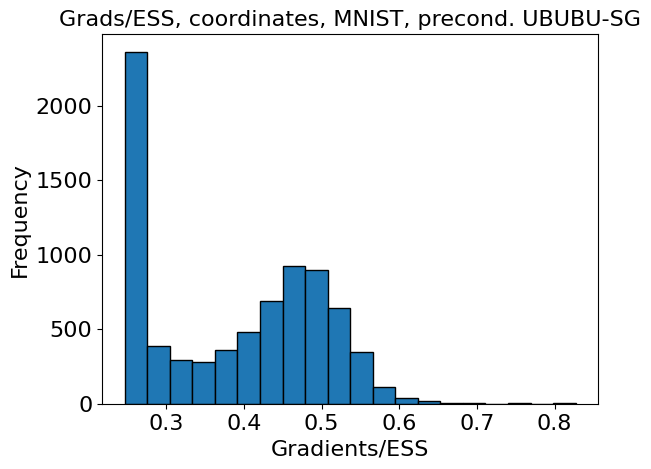

In [6]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
fig, ax = plt.subplots()
ax.set_xlabel("Gradients/ESS", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Grads/ESS, coordinates, MNIST, precond. UBUBU-SG",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
nbeta=7850
plt.hist(grad_per_ess[0:nbeta],bins=20,histtype='bar',edgecolor='black')
plt.savefig("./output/UBUBU_SG_MNIST_coordinates.pdf", format="pdf", bbox_inches='tight') 
plt.show()

<Figure size 640x480 with 0 Axes>

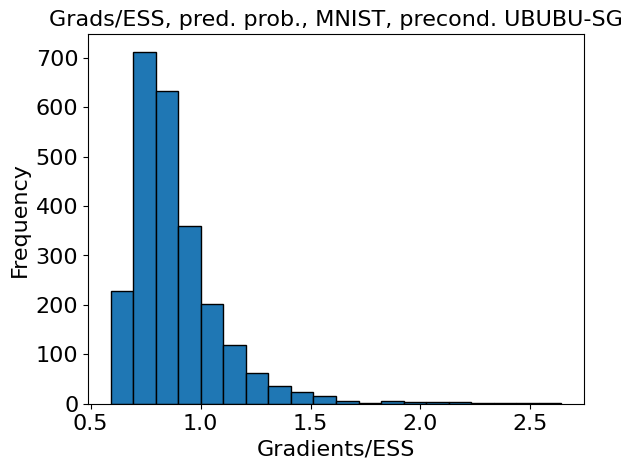

In [13]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
fig, ax = plt.subplots()
ax.set_xlabel("Gradients/ESS", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Grads/ESS, pred. prob., MNIST, precond. UBUBU-SG",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.hist(grad_per_ess[nbeta:],bins=20,histtype='bar',edgecolor='black')
plt.savefig("./output/UBUBU_SG_MNIST_prediction_prob.pdf", format="pdf", bbox_inches='tight') 
plt.show()